# Interval Tree Clock Benchmarks

To evaluate our interval tree clock implementation and the behaviour of interval tree clocks in general, we wrote benchmarks. These benchmarks test two implementations that are used like vector clocks in a fork-join setting.
This means that new replicas enter the system by forking an existing replica and leave the system by joining into an existing system. Failures are not modelled.
The first implementation is based on our interval tree clock implementation, the other one is based on scalas immutable `Map`, i.e., a traditional vector clock.
While the interval tree clock implementation uses `IdTree`s (part of the interval tree clock) for the ID, the vector clock uses randomly generated `Long` values as IDs.

We measure execution speeds, as well as the bandwidth overhead caused by the transmission of serialized timestamps.

## Description of Benchmarks

The benchmarks rely on a list of operations (aka. program) that are executed by the different clock implementations.
There are four operations that can be part of any such program:
- Event (on replica X)
- Fork (on replica X)
- Join (replica X with replica Y)
- Atomic send and receive (from replica X to replica Y)

The generation of these programs is parametrized. The following parameters exist:
- Length of the program (number of operations)
- Initial number of replicas at program start
- Probability of operation Event in percent
- Prob. of Fork
- Prob. of Join
- Prob. of Atomic send & receive

The probabilities are the basis of the decision which operation to generate at any point. Only valid operations are generated however, i.e., a join is only generated if at least two replicas would exist after executing every prior operation.
Every operation specifies one or two replicas to perform the operation on, these are randomly chosen.
Further details on the generation can be found in `ForkEventJoinProgram.scala`.

### Explanations of chosen parameters in program generation

There are four scenarios that we test. These are defined by their parameters.

1. init=1, E=25%, F=25%, J=25%, S&R=25%
> A highly dynamic system, replica membership changes quite frequently.

2. init=1, E=70%, F=5%, J=5%, S&R=20%
> A less dynamic system, replica membership still changes, but not as much as in 1.

3. init=10, E=60%, F=0%, J=0%, S&R=40%
> A static system, replica membership is constant with 10 replicas.

4. init=100, E=60%, F=0%, J=0%, S&R=40%
> A static system with more replicas, replica membership is constant with 100 replicas.

For each of these scenarios we generate 4 programs of differing length, but using the same seed for every program.

### Timing benchmarks

We wrote JMH benchmarks for measuring the average runtime for execution of the programs generated using a fixed seed and the parameters for the described 4 scenarios.
The tested implementations are based on:
- Interval tree clocks **without** serialization
- Interval tree clocks **with** serialization
- Vector clocks **without** serialization
- Vector clocks **with** serialization

Serialization and deserialization of the stamps happens for every operation except for the event operation, since an event is only local to a replica.
Encoding and decoding is based on the `FastIntervalTreeClockEncoder` or the `VectorClockStampEncoder` respectively.

### Bandwidth benchmarks

All of the benchmarks used for the timing measurements are reused for the logging of the bandwidth that is used by the operations.

## Important remarks
- Our vector clock implementation uses random IDs, when joining two replicas, one ID is "lost", i.e., it is kept in the vector clock but is never reused.
- Which replica is forked or which replicas are joined is randomly picked during generation.
In the interval tree clock case this might adversely affect the balance of the IdTree (and with that might affect performance).
At the start of a program, the `IdTree`s of the initial replicas are perfectly balanced, even when there are 100 initial replicas.
This is because the generation of initial replica IDs is implemented using a FIFO-Queue, i.e., forking happens in a round-robin manner instead of randomly selecting a replica to fork.
This might have benefited the performance of the interval tree clock benchmarks in the scenarios with a larger amount of initial replicas.

## How to reproduce the benchmark results

```sh
# To run the benchmarks and write the JMH results to results/times.csv
cd benchmarks
sbt "benchmarks/Jmh/run -rff results/times.csv"

# Setup Jupyter Lab in virtual environment (software to run this Notebook)
python -m venv env
source env/bin/activate
pip install pandas matplotlib jupyterlab
# Start the software to open this notebook
jupyter-lab
```

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('./results/times.csv')

def shortenName(benchString):
    return benchString.replace('de.tu_darmstadt.stg.daimpl.causality.benchmarks.ForkEventJoinSendReceiveBenchmark.' , '')

def fixFloatWithCommas(floatAsString):
    if isinstance(floatAsString, str):
        return float(floatAsString.replace(',','.'))
    else:
        return floatAsString

df['Score'] = df['Score'].map(fixFloatWithCommas)
df['Score Error (99,9%)'] = df['Score Error (99,9%)'].map(fixFloatWithCommas)
df['Benchmark'] = df['Benchmark'].map(shortenName)
df.drop(columns=['Threads', 'Samples'], inplace=True)

def avg_bandwidth(df: pd.DataFrame) -> pd.DataFrame:
    new_df = df[df.index % 100 == 0]
    new_df = new_df.diff()
    new_df /= 1024
    new_df = new_df.drop(index=new_df.index[0], axis=0)
    new_df = new_df.rename(columns={'bandwidth (bytes)': 'bandwidth (KiB/100ops)'})
    return new_df

def paramsToDescription(generationParams: str) -> str:
    paramArray = generationParams.split(',')
    return f"init={paramArray[0]}, E={paramArray[1]}%, F={paramArray[2]}%, J={paramArray[3]}%, S&R={paramArray[4]}%"

### Visualization of the Scenarios

On the left, we see the number of replicas that are active after executing every operation to this point (regardless of the implementation).

On the right, we see the total number of replicas that were created at some earlier point (again, regardless of the implementation).

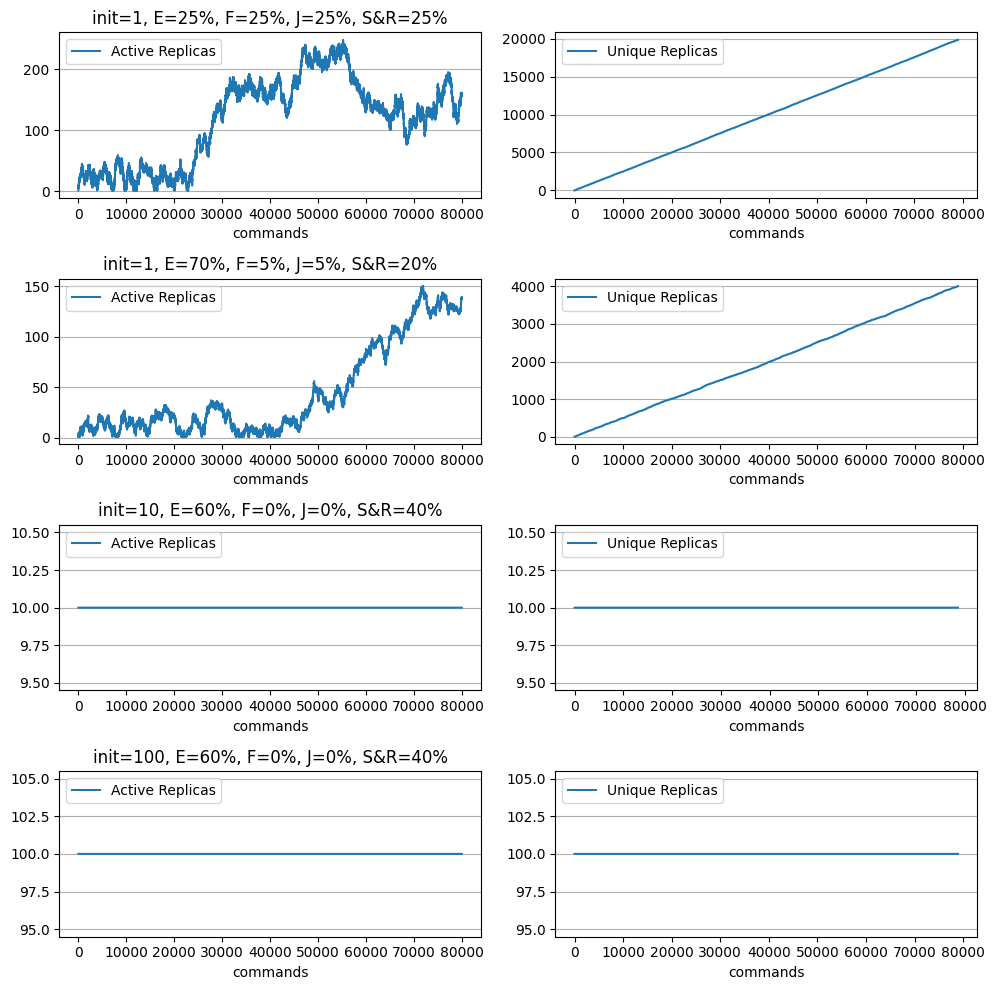

In [3]:
fig, axs = plt.subplots(4, 2, figsize=(10,10))

for ((ax1, ax2), param) in zip(axs, ['1,25,25,25,25', '1,70,5,5,20', '10,60,0,0,40', '100,60,0,0,40']):
    ax1.set_title(paramsToDescription(param))
    
    active_replicas = pd.read_csv(f'./results/active-replicas-{param}-80000.csv')
    active_replicas.plot(ax=ax1, x='commands', y='active replicas')
    ax1.legend(labels=['Active Replicas'], loc='upper left')#, title=paramsToDescription(param))
    
    unique_replicas = pd.read_csv(f'./results/all-replicas-{param}-80000.csv')
    unique_replicas.plot(ax=ax2, x='commands', y='unique replicas')
    ax2.legend(labels=['Unique Replicas'], loc='upper left')#, title=paramsToDescription(param))

for ax in axs.flatten():
    ax.grid(axis='y')

plt.tight_layout()

### Comparison of Program Runtime between Interval Tree Clock and Vector Clock

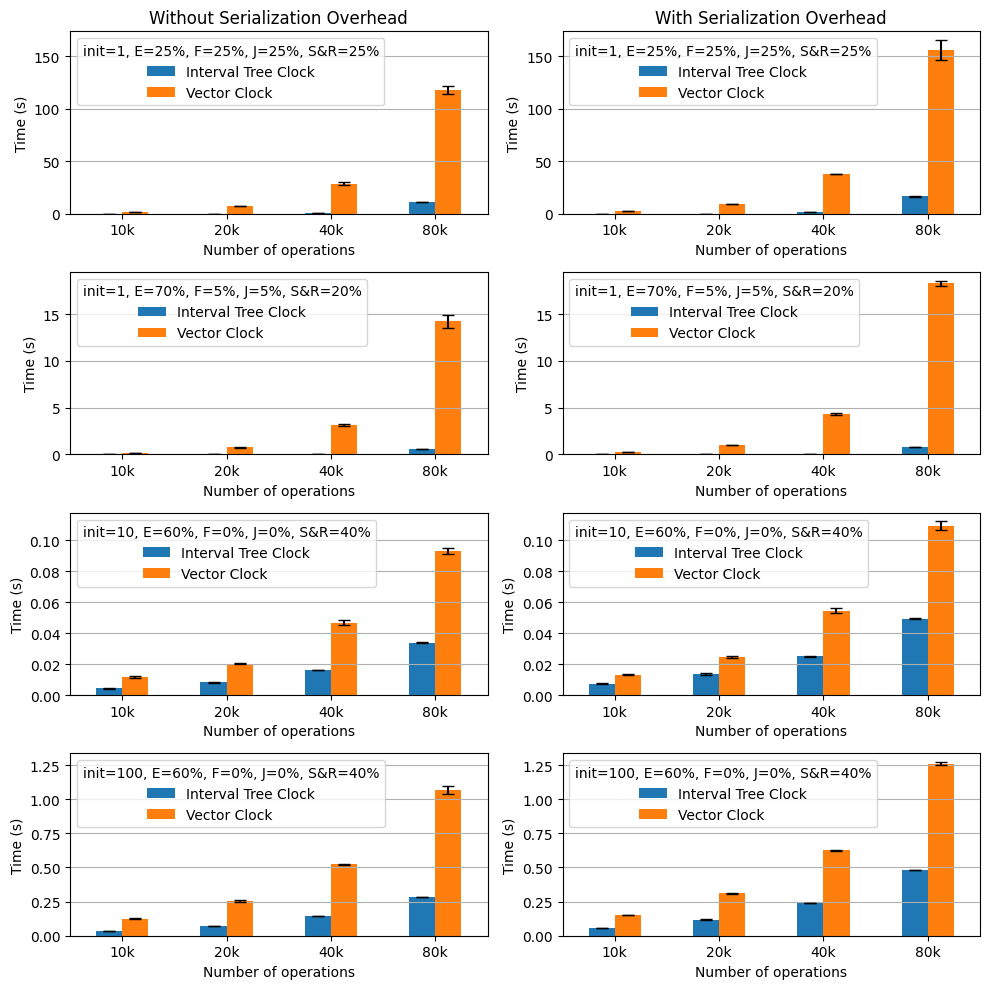

In [4]:
fig, axs = plt.subplots(4,2, figsize=(10,10))

axs[0][0].set_title('Without Serialization Overhead')
axs[0][1].set_title('With Serialization Overhead')

for ((ax_left, ax_right), param) in zip(axs, ['1,25,25,25,25', '1,70,5,5,20', '10,60,0,0,40', '100,60,0,0,40']):
    yMax = 0
    for (cur_ax, benchmarks) in [(ax_left, ['testIntervalTreeClock', 'testVectorClock']), (ax_right, ['testIntervalTreeClockWithSerialization', 'testVectorClockWithSerialization'])]:
        curBenchmarksDf = df[(df['Param: generationParams'] == param) & (df['Benchmark'].isin(benchmarks))]
        curBenchmarksDf = curBenchmarksDf.pivot(index='Param: programLength', columns='Benchmark', values=['Score', 'Score Error (99,9%)'])
        curBenchmarksDf.plot.bar(ax=cur_ax, y='Score', yerr='Score Error (99,9%)', capsize=4)
        cur_ax.set_xticklabels(curBenchmarksDf.index.map(lambda x: f"{int(x/1000)}k"), rotation=0)
        
        yMax = max(yMax, (curBenchmarksDf['Score'] + curBenchmarksDf['Score Error (99,9%)']).max().max())
    
    for ax in [ax_left, ax_right]:
        ax.set_ylim(0, yMax*1.05)
        ax.set_ylabel('Time (s)')
        ax.set_xlabel('Number of operations')
        ax.grid(axis='y')
        ax.legend(labels=['Interval Tree Clock', 'Vector Clock'], loc='upper left', title=paramsToDescription(param))

plt.tight_layout()

### Scalability of Interval Tree Clocks vs. Vector Clocks

Visualizes the average time to execute 1000 operations in the benchmark over the number of overall operations in the program.

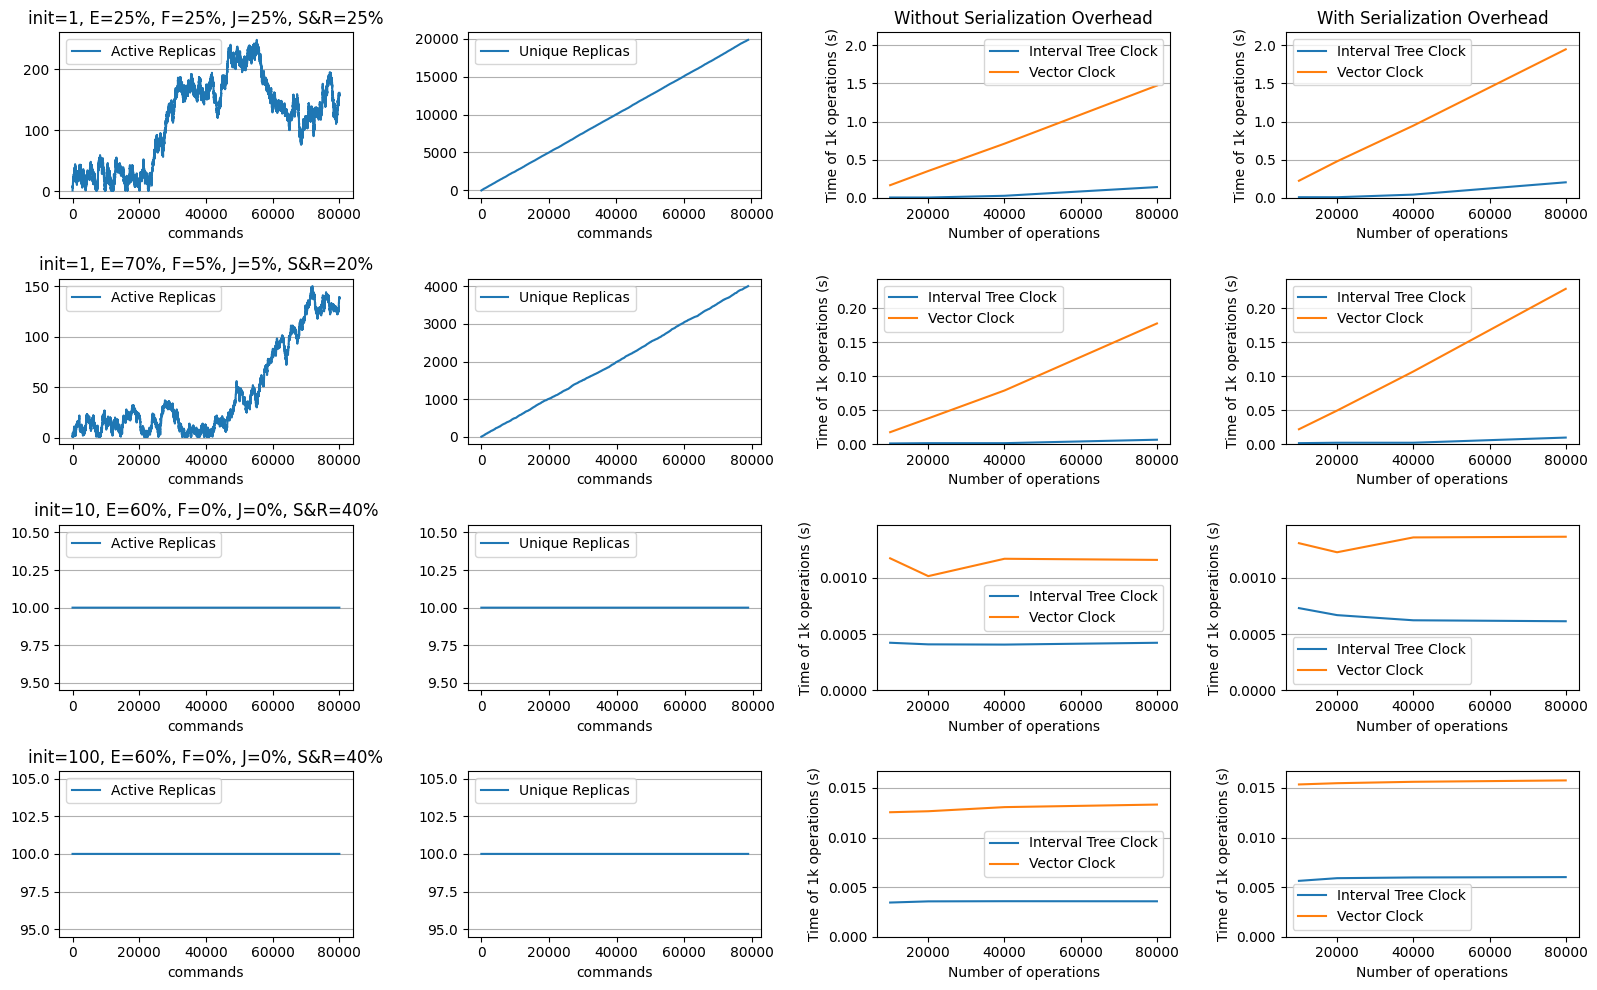

In [5]:
fig, axs = plt.subplots(4,4, figsize=(16,10))

for ((ax1, ax2), param) in zip([a[:2] for a in axs], ['1,25,25,25,25', '1,70,5,5,20', '10,60,0,0,40', '100,60,0,0,40']):
    ax1.set_title(paramsToDescription(param))

    active_replicas = pd.read_csv(f'./results/active-replicas-{param}-80000.csv')
    active_replicas.plot(ax=ax1, x='commands', y='active replicas')
    ax1.legend(labels=['Active Replicas'], loc='upper left')#, title=paramsToDescription(param))
    ax1.grid(axis='y')
    
    unique_replicas = pd.read_csv(f'./results/all-replicas-{param}-80000.csv')
    unique_replicas.plot(ax=ax2, x='commands', y='unique replicas')
    ax2.legend(labels=['Unique Replicas'], loc='upper left')
    ax2.grid(axis='y')

axs[0][2].set_title('Without Serialization Overhead')
axs[0][3].set_title('With Serialization Overhead')

for ((ax_left, ax_right), param) in zip([a[2:] for a in axs], ['1,25,25,25,25', '1,70,5,5,20', '10,60,0,0,40', '100,60,0,0,40']):
    yMax = 0
    for (cur_ax, benchmarks) in [(ax_left, ['testIntervalTreeClock', 'testVectorClock']), (ax_right, ['testIntervalTreeClockWithSerialization', 'testVectorClockWithSerialization'])]:
        curBenchmarksDf = df[(df['Param: generationParams'] == param) & (df['Benchmark'].isin(benchmarks))].copy()
        curBenchmarksDf['Score'] /= (curBenchmarksDf['Param: programLength'] / 1000)
        curBenchmarksDf['Score Error (99,9%)'] /= (curBenchmarksDf['Param: programLength'] / 1000)
        curBenchmarksDf = curBenchmarksDf.pivot(index='Param: programLength', columns='Benchmark', values=['Score', 'Score Error (99,9%)'])
        curBenchmarksDf.plot.line(ax=cur_ax, y='Score')
        
        yMax = max(yMax, (curBenchmarksDf['Score'] + curBenchmarksDf['Score Error (99,9%)']).max().max())
    
    for ax in [ax_left, ax_right]:
        ax.set_ylim(0, yMax*1.05)
        ax.set_ylabel('Time of 1k operations (s)')
        ax.set_xlabel('Number of operations')
        ax.grid(axis='y')
        ax.legend(labels=['Interval Tree Clock', 'Vector Clock'])
        
plt.tight_layout()

### Bandwidth used by Interval Tree Clocks vs Vector Clocks

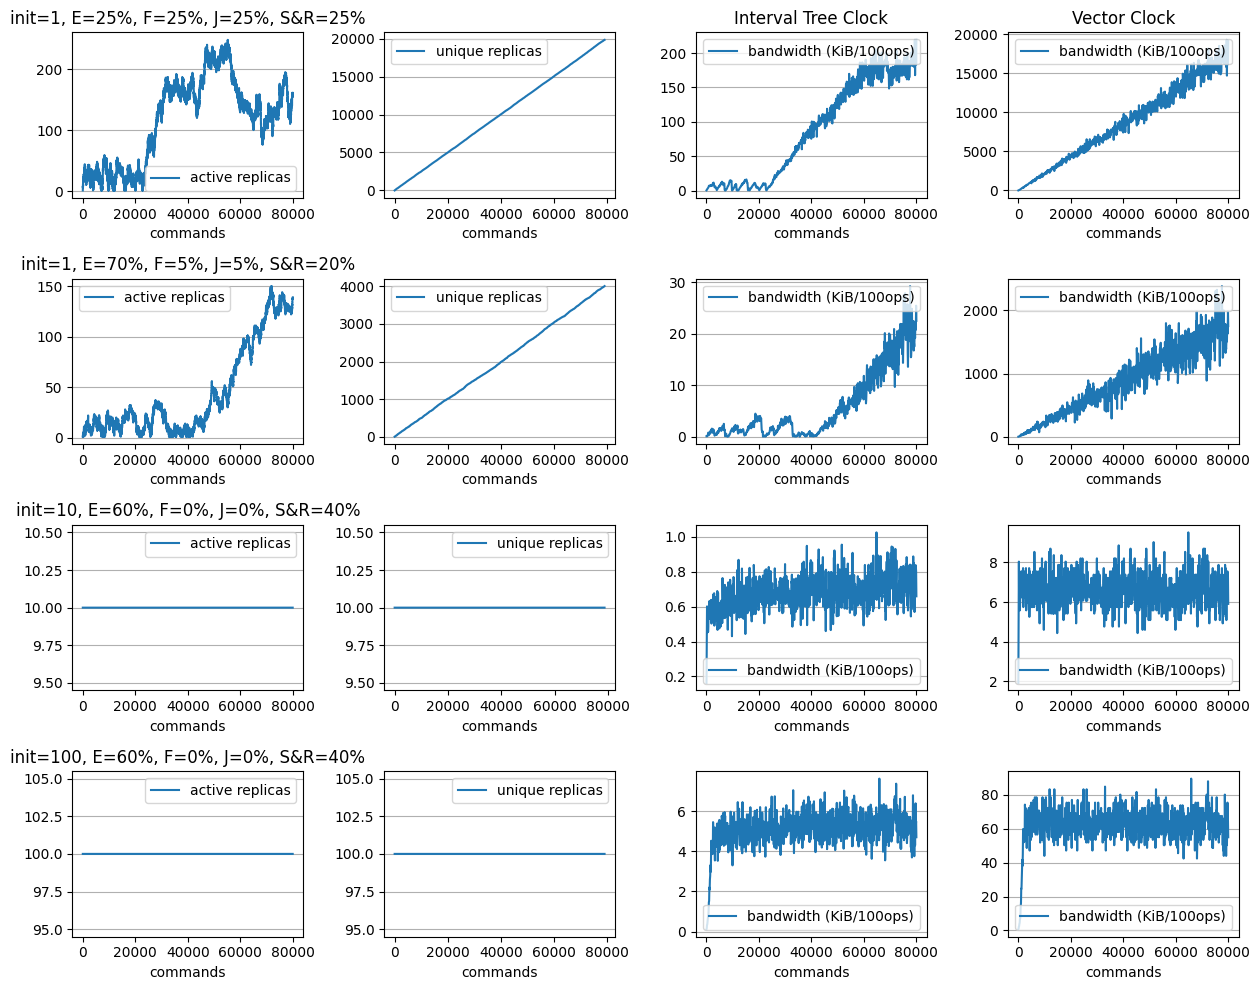

In [6]:
fig, axs = plt.subplots(4, 4, figsize=(12.5,10))

axs[0][2].set_title('Interval Tree Clock')
axs[0][3].set_title('Vector Clock')

for ((ax1, ax2, ax3, ax4), param) in zip(axs, ['1,25,25,25,25', '1,70,5,5,20', '10,60,0,0,40', '100,60,0,0,40']):
    ax1.set_title(paramsToDescription(param))
    
    active_replicas = pd.read_csv(f'./results/active-replicas-{param}-80000.csv')
    active_replicas.plot(ax=ax1, x='commands', y='active replicas')

    unique_replicas = pd.read_csv(f'./results/all-replicas-{param}-80000.csv')
    unique_replicas.plot(ax=ax2, x='commands', y='unique replicas')

    bandwidth_itc = pd.read_csv(f'./results/itc-bandwidth-{param}-80000.csv').set_index('commands')
    bandwidth_itc = avg_bandwidth(bandwidth_itc)
    bandwidth_itc.plot(ax=ax3)
    
    bandwidth_vc = pd.read_csv(f'./results/vc-bandwidth-{param}-80000.csv').set_index('commands')
    bandwidth_vc = avg_bandwidth(bandwidth_vc)
    bandwidth_vc.plot(ax=ax4)

for ax in axs.flatten():
    ax.grid(axis='y')

plt.tight_layout()